In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,Subset
from torchvision import models, transforms
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


/Applications/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
CLASS_NAMES = ['style', 'genre', 'artist']
CLASS_SIZE=[27,11,129]
BATCH_SIZE=128
EPOCHS=25
CURR_CLASS=CLASS_NAMES[0]
CURR_CLASS_SIZE=CLASS_SIZE[0]

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(           
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class WikiArtDataset(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        image = item['image']
        label = item[CURR_CLASS]
        if self.transform:
            image = self.transform(image)
        return image, label
    
ds = load_dataset("huggan/wikiart")['train']

print(f"Total dataset size: {len(ds)}")

ds_train_val = ds.train_test_split(test_size=0.2, shuffle=True, seed=42)
train_ds = ds_train_val['train']
val_ds = ds_train_val['test']

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

train_dataset = WikiArtDataset(train_ds, transform=transform)
val_dataset = WikiArtDataset(val_ds, transform=transform)

# sample_fraction = 0.1  
# train_sample_size = int(len(train_dataset) * sample_fraction)
# val_sample_size = int(len(val_dataset) * sample_fraction)

# train_indices = torch.randperm(len(train_dataset))[:train_sample_size].tolist()
# val_indices = torch.randperm(len(val_dataset))[:val_sample_size].tolist()

train_subset = train_dataset
val_subset = val_dataset


print(f"Length of train_subset: {len(train_subset)}")
print(f"Length of val_subset: {len(val_subset)}")

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, CURR_CLASS_SIZE) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'\nEpoch [{epoch+1}/{EPOCHS}]')
    train_loader_iter = tqdm(train_loader, desc='Training')

    for images, labels in train_loader_iter:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loader_iter.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f'Training Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_loader_iter = tqdm(val_loader, desc='Validation')
    with torch.no_grad():
        for images, labels in val_loader_iter:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            val_loader_iter.set_postfix(loss=loss.item())

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    print(f'Validation Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}')
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

Resolving data files: 100%|██████████| 72/72 [00:00<00:00, 224.36it/s]


Total dataset size: 81444
Training dataset size: 65155
Validation dataset size: 16289
Type of train_indices: <class 'list'>
Length of train_indices: 6515
Length of train_subset: 6515
Length of val_subset: 1628
Using device: mps


/Applications/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Applications/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [1/25]


Training: 100%|██████████| 51/51 [02:21<00:00,  2.78s/it, loss=2.01]


Training Loss: 2.3200, Acc: 0.3202


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.46s/it, loss=2.05]


Validation Loss: 1.9586, Acc: 0.3839

Epoch [2/25]


Training: 100%|██████████| 51/51 [02:18<00:00,  2.72s/it, loss=1.4] 


Training Loss: 1.3746, Acc: 0.6055


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it, loss=1.79]


Validation Loss: 1.7511, Acc: 0.4337

Epoch [3/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.67s/it, loss=0.751]


Training Loss: 0.8280, Acc: 0.8063


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.40s/it, loss=1.76]


Validation Loss: 1.7005, Acc: 0.4570

Epoch [4/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.68s/it, loss=0.369]


Training Loss: 0.4090, Acc: 0.9424


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.40s/it, loss=1.82]


Validation Loss: 1.7313, Acc: 0.4582

Epoch [5/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it, loss=0.157]


Training Loss: 0.1772, Acc: 0.9866


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.40s/it, loss=1.84]


Validation Loss: 1.7527, Acc: 0.4748

Epoch [6/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it, loss=0.0698]


Training Loss: 0.0849, Acc: 0.9971


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it, loss=1.86]


Validation Loss: 1.7773, Acc: 0.4699

Epoch [7/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.70s/it, loss=0.0341]


Training Loss: 0.0492, Acc: 0.9983


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.37s/it, loss=1.88]


Validation Loss: 1.7993, Acc: 0.4705

Epoch [8/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.70s/it, loss=0.0285]


Training Loss: 0.0319, Acc: 0.9994


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.40s/it, loss=1.92]


Validation Loss: 1.8223, Acc: 0.4736

Epoch [9/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.70s/it, loss=0.0224]


Training Loss: 0.0241, Acc: 0.9991


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.38s/it, loss=1.9] 


Validation Loss: 1.8516, Acc: 0.4717

Epoch [10/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it, loss=0.0189]


Training Loss: 0.0184, Acc: 0.9991


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.41s/it, loss=1.96]


Validation Loss: 1.8594, Acc: 0.4730

Epoch [11/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.70s/it, loss=0.0127] 


Training Loss: 0.0140, Acc: 0.9991


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.42s/it, loss=1.97]


Validation Loss: 1.8728, Acc: 0.4742

Epoch [12/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it, loss=0.0119] 


Training Loss: 0.0123, Acc: 0.9991


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.41s/it, loss=2.04]


Validation Loss: 1.9054, Acc: 0.4779

Epoch [13/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.68s/it, loss=0.00821]


Training Loss: 0.0102, Acc: 0.9992


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.35s/it, loss=2.05]


Validation Loss: 1.9209, Acc: 0.4717

Epoch [14/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it, loss=0.00822]


Training Loss: 0.0087, Acc: 0.9995


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.42s/it, loss=2.05]


Validation Loss: 1.9274, Acc: 0.4742

Epoch [15/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.68s/it, loss=0.00601]


Training Loss: 0.0081, Acc: 0.9989


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.37s/it, loss=2.04]


Validation Loss: 1.9355, Acc: 0.4730

Epoch [16/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it, loss=0.0059] 


Training Loss: 0.0067, Acc: 0.9992


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.41s/it, loss=2.07]


Validation Loss: 1.9532, Acc: 0.4760

Epoch [17/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.68s/it, loss=0.0268] 


Training Loss: 0.0063, Acc: 0.9992


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it, loss=2.09]


Validation Loss: 1.9814, Acc: 0.4625

Epoch [18/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.68s/it, loss=0.00423]


Training Loss: 0.0055, Acc: 0.9994


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.40s/it, loss=2.07]


Validation Loss: 1.9641, Acc: 0.4730

Epoch [19/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.69s/it, loss=0.00328]


Training Loss: 0.0053, Acc: 0.9994


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it, loss=2.08]


Validation Loss: 1.9784, Acc: 0.4748

Epoch [20/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.68s/it, loss=0.0034] 


Training Loss: 0.0047, Acc: 0.9992


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it, loss=2.11]


Validation Loss: 2.0057, Acc: 0.4717

Epoch [21/25]


Training: 100%|██████████| 51/51 [02:16<00:00,  2.69s/it, loss=0.00261]


Training Loss: 0.0045, Acc: 0.9992


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.40s/it, loss=2.14]


Validation Loss: 2.0017, Acc: 0.4674

Epoch [22/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.69s/it, loss=0.00347]


Training Loss: 0.0042, Acc: 0.9989


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.41s/it, loss=2.16]


Validation Loss: 2.0180, Acc: 0.4699

Epoch [23/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.70s/it, loss=0.00243]


Training Loss: 0.0046, Acc: 0.9991


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.42s/it, loss=2.14]


Validation Loss: 2.0167, Acc: 0.4717

Epoch [24/25]


Training: 100%|██████████| 51/51 [02:17<00:00,  2.70s/it, loss=0.00197]


Training Loss: 0.0036, Acc: 0.9994


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.40s/it, loss=2.17]


Validation Loss: 2.0282, Acc: 0.4693

Epoch [25/25]


Training: 100%|██████████| 51/51 [02:18<00:00,  2.71s/it, loss=0.00152]


Training Loss: 0.0034, Acc: 0.9991


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.41s/it, loss=2.16]

Validation Loss: 2.0401, Acc: 0.4668


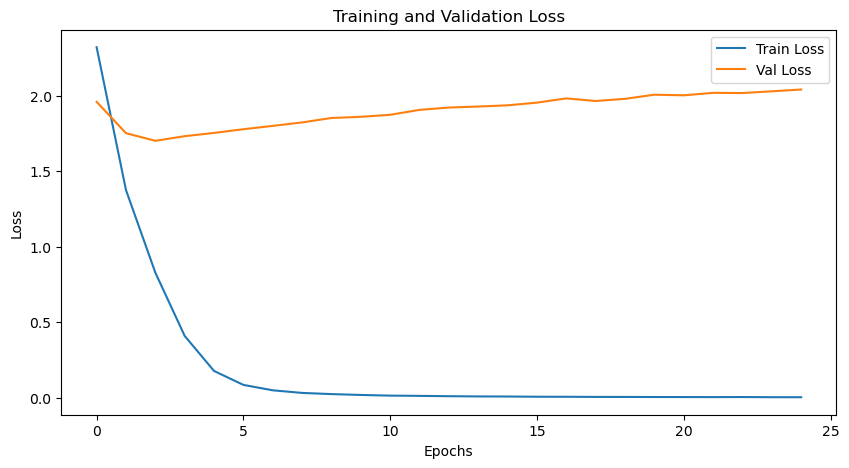

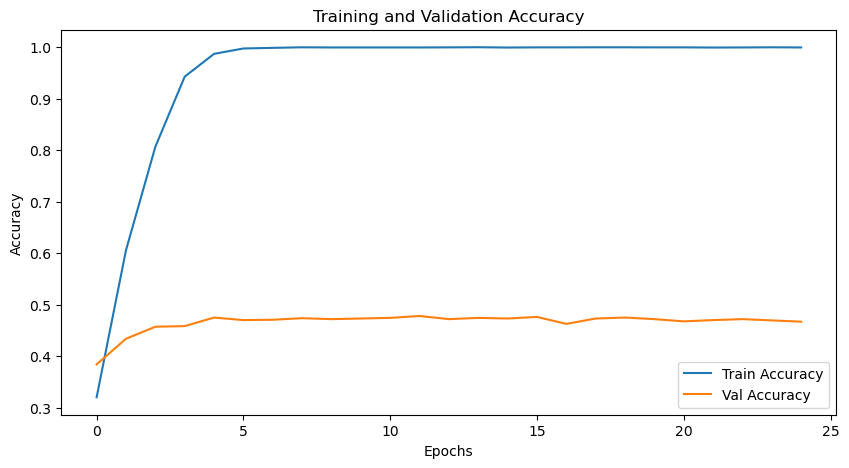

In [6]:
# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies,label="Train Accuracy")
plt.plot(val_accuracies,label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()